<a href="https://colab.research.google.com/github/Tharunvikas55/reasearch-project/blob/main/final2EfficientNetB7_resnet_denseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EfficientNetB7

In [ ]:
from tqdm.keras import TqdmCallback
from skimage import transform
import requests
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
import datetime
from keras.layers import Dense, Dropout, Activation

# path variables
train_path = '/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train'
Batch_size = 32
img_height = 300  # reduced from 600 to mitigate the memory issue
img_width = 300   # reduced from 600 to mitigate the memory issue
IMAGE_SHAPE=(img_height,img_width)
seed_train_validation = 1
shuffle_value = True
validation_split = 0.4
# load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=validation_split,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=Batch_size,
  seed = seed_train_validation,
  shuffle = shuffle_value )
# load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=Batch_size,
    seed = seed_train_validation,
    shuffle = shuffle_value )
directory = "/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Original Images/Original Images/FOLDS/fold5/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
     # We only detect if it is nor isn't a hotdog so binary is fine
    color_mode="rgb",
    batch_size=Batch_size,
    image_size=(img_height, img_width),
)
class_names = train_ds.class_names
print("the target classes are: ",*class_names, sep =" ,")
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
efficientnet_b7_fv = 'https://kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b7-feature-vector/versions/1'
feature_extractor_model = efficientnet_b7_fv
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False)
num_classes = len(class_names)

Found 4217 files belonging to 6 classes.
Using 2531 files for training.
Found 4217 files belonging to 6 classes.
Using 1686 files for validation.
Found 63 files belonging to 6 classes.
the target classes are:  ,Chickenpox ,Cowpox ,HFMD ,Healthy ,Measles ,Monkeypox


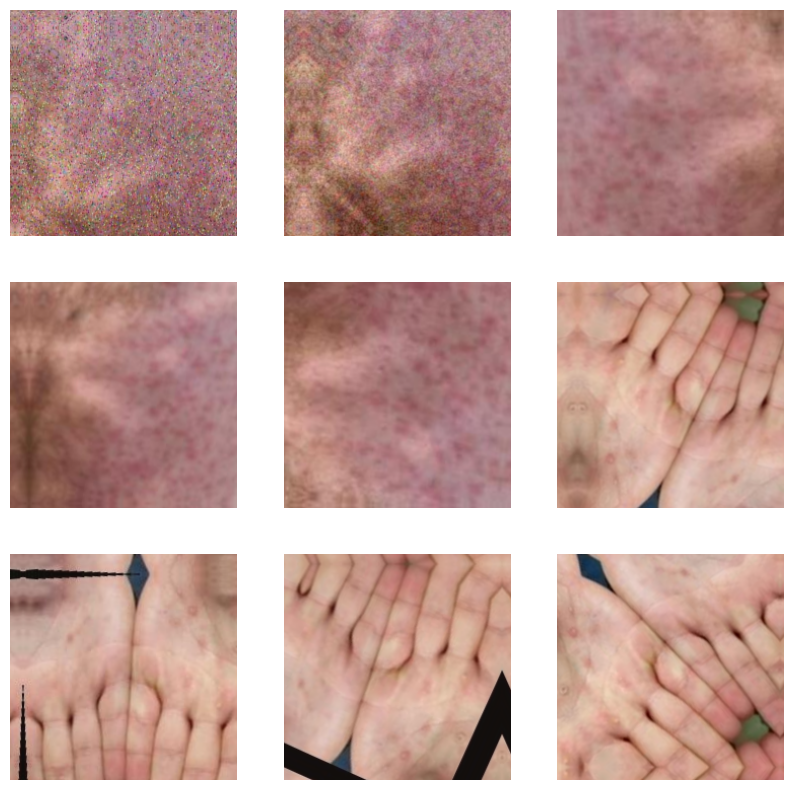

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from PIL import Image
import tensorflow as tf
image_dir = '/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox'
img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)
image_files = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i in range(9):
    img_path = os.path.join(image_dir, image_files[i])
    img = Image.open(img_path)
    img = image.img_to_array(img)
    augmented_image = img_augmentation(img)
    augmented_image = augmented_image.numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.astype("uint8"))
    plt.axis("off")

plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2560)              64097680  
                                                                 
 dense (Dense)               (None, 6)                 15366     
                                                                 
Total params: 64113046 (244.57 MB)
Trainable params: 15366 (60.02 KB)
Non-trainable params: 64097680 (244.51 MB)
_________________________________________________________________


0epoch [00:00, ?epoch/s]


 Accuracy Reached: 97.55%


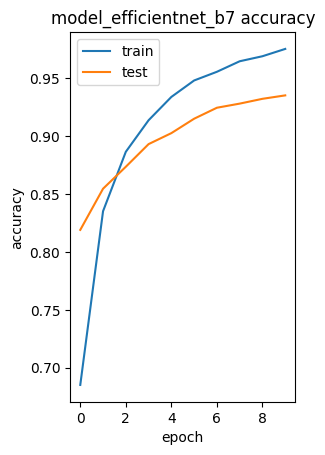

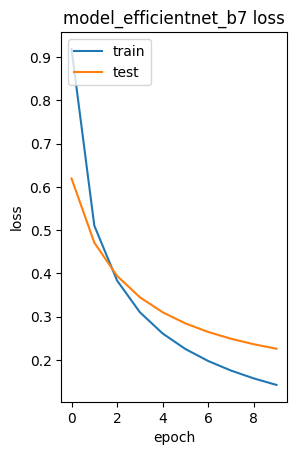

In [ ]:
import tensorflow as tf
model_efficientnet_b7 = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])
model_efficientnet_b7.summary()
model_efficientnet_b7.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
NUM_EPOCHS = 10
history_efficientnet_b7 = model_efficientnet_b7.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, TqdmCallback(verbose=0)],verbose=0)
model_acc_efficientnet_b7 = '{:.2%}'.format(history_efficientnet_b7.history['acc'][-1])
print(f"\n Accuracy Reached: {model_acc_efficientnet_b7}")
plt.subplot(1,2,1)
plt.plot(history_efficientnet_b7.history['acc'])
plt.plot(history_efficientnet_b7.history['val_acc'])
plt.title('model_efficientnet_b7 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_efficientnet_b7 for loss
plt.subplot(1,2,2)
plt.plot(history_efficientnet_b7.history['loss'])
plt.plot(history_efficientnet_b7.history['val_loss'])
plt.title('model_efficientnet_b7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


ResNetV2

Found 4217 files belonging to 6 classes.
Using 3374 files for training.
Found 4217 files belonging to 6 classes.
Using 843 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 224)               224448    
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1350      
                                                                 
Total params: 25841647 (98.58 MB)
Trainable para

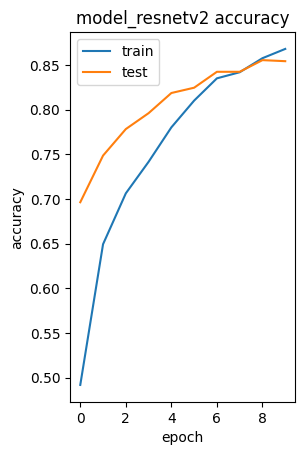

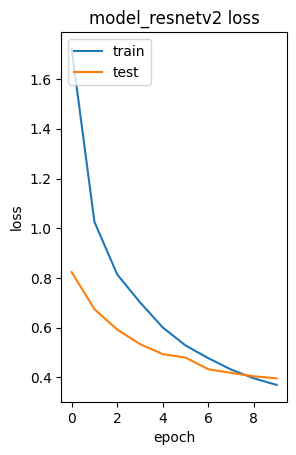

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython.display import clear_output
import tensorflow_hub as hub
train_path = '/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train'
IMG_SIZE = (300, 300)
Batch_size=32
SHUFFLE_BUFFER = 1000
PRETRAINED_MODEL_PATH = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2"
validation_split = 0.2
NUM_EPOCHS = 10
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=Batch_size,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=validation_split,
    subset='training',
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=Batch_size,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=validation_split,
    subset='validation',
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

training_data = (train_dataset.map(lambda x,y: (data_augmentation(x), y))
                 .shuffle(SHUFFLE_BUFFER).prefetch(1).cache())
validation_data = (validation_dataset.map(lambda x,y: (normalization(x), y))
                   .prefetch(1).cache())

keras_layer = hub.KerasLayer(PRETRAINED_MODEL_PATH)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss')
]

class_names = train_dataset.class_names
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = keras_layer(inputs)
x = tf.keras.layers.Dense(224, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_resnev2 = keras.Model(inputs, outputs)
model_resnev2.summary()

model_resnev2.compile(loss='categorical_crossentropy',
             optimizer=rmsprop,
             metrics=['accuracy'])

history_resnetv2 = model_resnev2.fit(training_data,
                    epochs=NUM_EPOCHS,
                    validation_data=validation_data,
                    callbacks=callbacks)

# view model_efficientnet_b7 accuracy
modelresnetv2 = '{:.2%}'.format(history_resnetv2.history['accuracy'][-1])
print(f"\n Model Accuracy Reached: {modelresnetv2}")

# # summarize history_efficientnet_b7 for accuracy
plt.subplot(1,2,1)
plt.plot(history_resnetv2.history['accuracy'])
plt.plot(history_resnetv2.history['val_accuracy'])
plt.title('model_resnetv2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_efficientnet_b7 for loss
plt.subplot(1,2,2)
plt.plot(history_resnetv2.history['loss'])
plt.plot(history_resnetv2.history['val_loss'])
plt.title('model_resnetv2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already trained your model and have predictions
# Get the true labels from the validation dataset
true_labels = np.concatenate([y for x, y in validation_data], axis=0)

# Normalize the predicted probabilities to get class predictions
predicted_probabilities = model_resnev2.predict(validation_data)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Convert one-hot encoded labels to integers
true_labels = np.argmax(true_labels, axis=1)

# Create a classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(class_report)


27/27 [==============================] - 4s 147ms/step
              precision    recall  f1-score   support

  Chickenpox       0.62      0.77      0.69        66
      Cowpox       0.92      0.78      0.85        77
        HFMD       0.96      0.84      0.90        82
     Healthy       0.74      0.91      0.82        76
     Measles       0.80      0.82      0.81        83
   Monkeypox       0.90      0.88      0.89       459

    accuracy                           0.85       843
   macro avg       0.82      0.83      0.82       843
weighted avg       0.86      0.85      0.86       843



DenseNet121

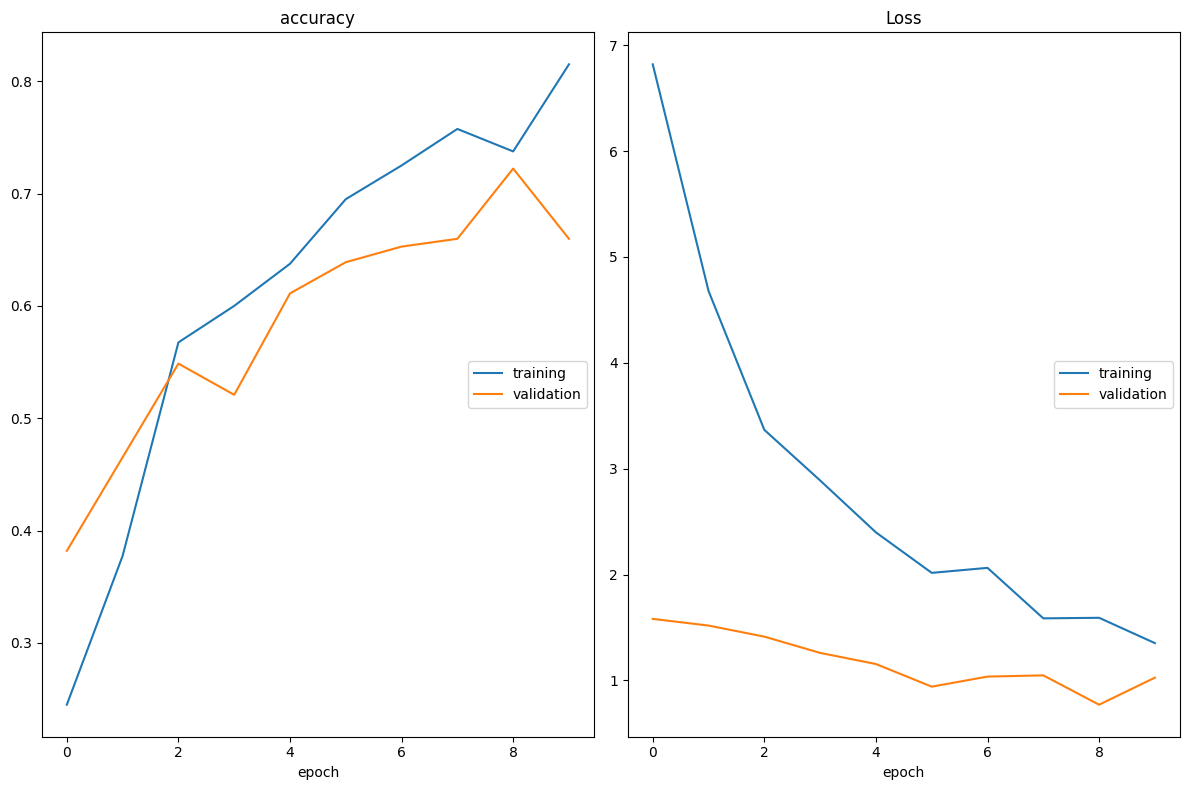

accuracy
	training         	 (min:    0.245, max:    0.815, cur:    0.815)
	validation       	 (min:    0.382, max:    0.722, cur:    0.660)
Loss
	training         	 (min:    1.353, max:    6.819, cur:    1.353)
	validation       	 (min:    0.771, max:    1.581, cur:    1.026)
4/4 [==============================] - 5s 687ms/step
DenseNet121-based Model Accuracy: 71.43%
Precision: 0.753
Recall: 0.690
F1 Score: 0.708
Classification Report
              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.80      0.57      0.67         7
           2       0.62      0.87      0.72        15
           3       0.73      0.80      0.76        10
           4       1.00      0.67      0.80         6
           5       0.80      0.67      0.73        18

    accuracy                           0.71        63
   macro avg       0.75      0.69      0.71        63
weighted avg       0.74      0.71      0.71        63



In [ ]:
import os
import numpy as np
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
from PIL import Image
from scipy import misc
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model

from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Add, Multiply, Subtract, AveragePooling2D
from keras.layers import Activation, SpatialDropout2D
from keras.layers import Dense, Lambda
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, Flatten

from tensorflow.keras.utils import plot_model

from keras.optimizers import *
from keras.callbacks import *
from keras.activations import *

from sklearn.metrics import classification_report, confusion_matrix


np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
train_loc = '/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train'
val_loc = '/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Original Images/Original Images/FOLDS/fold5/Valid'
test_loc = '/content/drive/MyDrive/R&D/datasets/Mpox Skin Lesion Dataset Version 2.0 (MSLD v2.0)/Original Images/Original Images/FOLDS/fold5/Test'


BATCH_SIZE = 16
trdata = ImageDataGenerator()
train_data = trdata.flow_from_directory(directory=train_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

vdata = ImageDataGenerator()
val_data = vdata.flow_from_directory(directory=val_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

tsdata = ImageDataGenerator()
test_data = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=False, seed = 42)

from tensorflow.keras.applications import DenseNet121

def create_model(input_shape, n_classes , optimizer, fine_tune):
    conv_base = DenseNet121(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.15)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
n_classes = 6
ft=0

# First we'll train the model without Fine-tuning
model = create_model(input_shape, n_classes, opt, ft)


!pip install livelossplot

STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//test_data.batch_size
#n_epochs = 100


from collections import Counter
counter = Counter(train_data.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

from livelossplot import PlotLossesKeras

checkpoint = ModelCheckpoint("../working/DenseNet121Full.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(train_data,
                    epochs =10,
                    steps_per_epoch = 25,
                    class_weight = class_weights,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks=[checkpoint, early_stop, PlotLossesKeras()]
                    )

model_preds = model.predict(test_data,test_data.samples//test_data.batch_size+1)
model_pred_classes = np.argmax(model_preds , axis=1)


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, model_pred_classes)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, model_pred_classes,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, model_pred_classes,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, model_pred_classes,average='macro'))

print('Classification Report')
target_names = ['Chickenpox','Cowpox','HFMD','Healthy','Measles','Monkeypox']
print(classification_report(test_data.classes, model_pred_classes))

In [ ]:
import matplotlib.pyplot as plt
accuracy_efficient=97.55
accuracy_resnet=86.46
accuracy_DenseNet=71


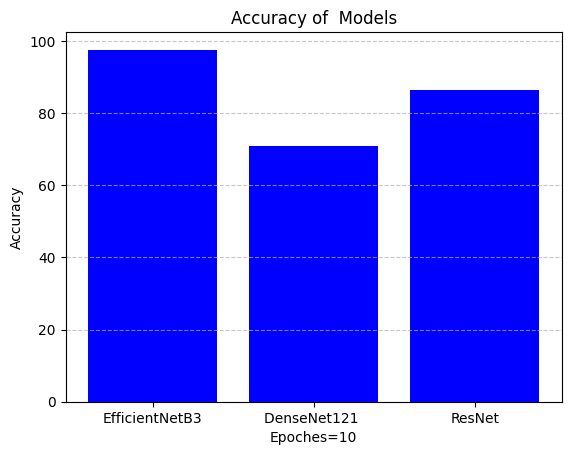

In [ ]:
accuracy_values = [accuracy_efficient, accuracy_DenseNet , accuracy_resnet]
colors = ['blue', 'blue','blue']
bar_chart = plt.bar(['EfficientNetB3', 'DenseNet121 ','ResNet'], accuracy_values, color=colors)
value=[accuracy_efficient, accuracy_DenseNet , accuracy_resnet]
plt.xlabel('Epoches=10')
plt.ylabel('Accuracy')
plt.title('Accuracy of  Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Get the names of the ten classes
class_names = test_data.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Greens, #Blues, YlGnBu, YlOrRd
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

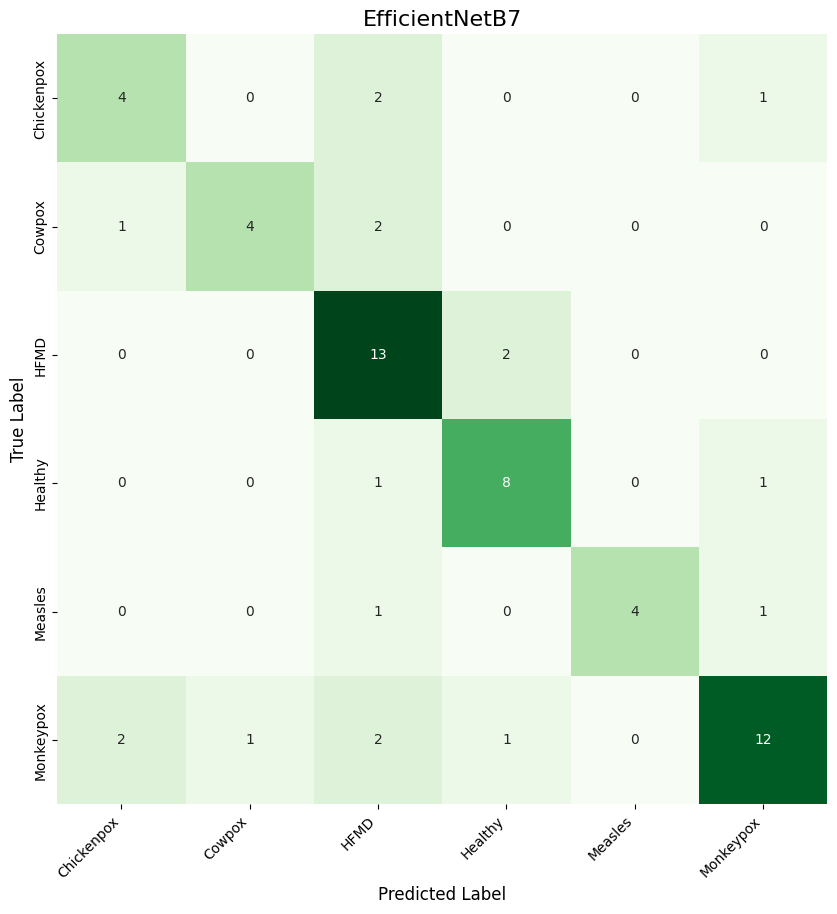

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
plot_heatmap(true_classes, model_pred_classes, class_names, ax1, title="EfficientNetB7")